# **Imports**

In [3]:
!pip install norse

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.4 MB/s e

In [4]:
import pandas as pd
import torch
import torch.nn as nn
import norse.torch as snn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import numpy as np

**CSV**

In [7]:
data = pd.read_csv('Features_combined.csv')

print(data.head())

           0           1          2          3          4          5  \
0 -642.06090  108.210945 -10.606920  67.186120 -14.965309  21.728197   
1 -634.53455  138.745180 -25.565720  45.151340  -7.399083  19.283112   
2 -363.18735  146.278460 -68.896740  52.735188 -18.276760  31.332811   
3 -100.85547  176.889480 -40.686780  33.945950  -1.921574  30.010950   
4 -105.10822  178.339100 -42.301815  31.098093   3.495722  34.628902   

          6          7          8          9  ...        31        32  \
0  2.582888  11.604472 -24.652874  17.227154  ...  0.019952 -0.010839   
1  2.707990   8.712544  -8.491128  13.053898  ... -0.011474  0.003522   
2 -2.968685  16.404285   5.250308   6.494044  ... -0.011669  0.011385   
3  4.855892  10.836736 -10.383341   4.186645  ... -0.047365 -0.014389   
4  5.231517  12.170620 -11.026355   5.266486  ... -0.020646 -0.003456   

         33        34        35        36        37        38  Label  \
0  0.036636  0.005185  0.013216 -0.012983  0.020524  0.0

# **Splitting X,Y**

In [18]:
X = data.drop(columns=['Label','File_Name' ])
y = data['Label']

le = LabelEncoder()
y = le.fit_transform(y)


# **Adjusting the data shape and form**

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# the tensor shape is [batch size = 64, freq = 1 implect, input = 39]
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [25]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# **Creating the model**

In [23]:
class SNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.lif1 = snn.LIFCell()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.lif2 = snn.LIFCell()
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x, num_steps=15):
        state1 = None
        state2 = None
        outputs = []
        for _ in range(num_steps):
            z1 = self.fc1(x)
            spk1, state1 = self.lif1(z1, state1)
            z2 = self.fc2(spk1)
            spk2, state2 = self.lif2(z2, state2)
            z3 = self.fc3(spk2)
            outputs.append(z3)
        return torch.stack(outputs).sum(dim=0)

input_size = X_train.shape[1]
hidden_size = 64
num_classes = len(le.classes_)
num_steps = 15

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SNN(input_size, hidden_size, num_classes).to(device)
class_counts = pd.Series(y_train).value_counts().sort_index()
weights = torch.tensor([1.0 / count for count in class_counts], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# old learning rate
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

patience = 5
best_loss = float('inf')
counter = 0

# **Training the Model**

In [26]:
for epoch in range(50):
    model.train()
    epoch_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, num_steps)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    print(f"Epoch [{epoch+1}/{50}], Loss: {epoch_loss:.4f}")
    scheduler.step()


    if epoch_loss < best_loss:
        best_loss = epoch_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

Epoch [1/50], Loss: 0.9953
Epoch [2/50], Loss: 0.8795
Epoch [3/50], Loss: 0.8359
Epoch [4/50], Loss: 0.8023
Epoch [5/50], Loss: 0.7788
Epoch [6/50], Loss: 0.7306
Epoch [7/50], Loss: 0.7151
Epoch [8/50], Loss: 0.7102
Epoch [9/50], Loss: 0.6981
Epoch [10/50], Loss: 0.6902
Epoch [11/50], Loss: 0.6659
Epoch [12/50], Loss: 0.6579
Epoch [13/50], Loss: 0.6546
Epoch [14/50], Loss: 0.6505
Epoch [15/50], Loss: 0.6485
Epoch [16/50], Loss: 0.6358
Epoch [17/50], Loss: 0.6325
Epoch [18/50], Loss: 0.6309
Epoch [19/50], Loss: 0.6314
Epoch [20/50], Loss: 0.6290
Epoch [21/50], Loss: 0.6226
Epoch [22/50], Loss: 0.6213
Epoch [23/50], Loss: 0.6189
Epoch [24/50], Loss: 0.6206
Epoch [25/50], Loss: 0.6191
Epoch [26/50], Loss: 0.6152
Epoch [27/50], Loss: 0.6147
Epoch [28/50], Loss: 0.6142
Epoch [29/50], Loss: 0.6131
Epoch [30/50], Loss: 0.6141
Epoch [31/50], Loss: 0.6123
Epoch [32/50], Loss: 0.6129
Epoch [33/50], Loss: 0.6127
Epoch [34/50], Loss: 0.6136
Epoch [35/50], Loss: 0.6125
Epoch [36/50], Loss: 0.6116
E

# **Evaluation**

In [27]:
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs, num_steps)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

Accuracy: 0.7083

Classification Report:
              precision    recall  f1-score   support

       Anger       0.81      0.72      0.76      1988
        Fear       0.61      0.65      0.63      1833
   Happiness       0.64      0.60      0.62      1901
     Neutral       0.73      0.78      0.76      1750
     Sadness       0.77      0.79      0.78      1715

    accuracy                           0.71      9187
   macro avg       0.71      0.71      0.71      9187
weighted avg       0.71      0.71      0.71      9187



# **Visualization**

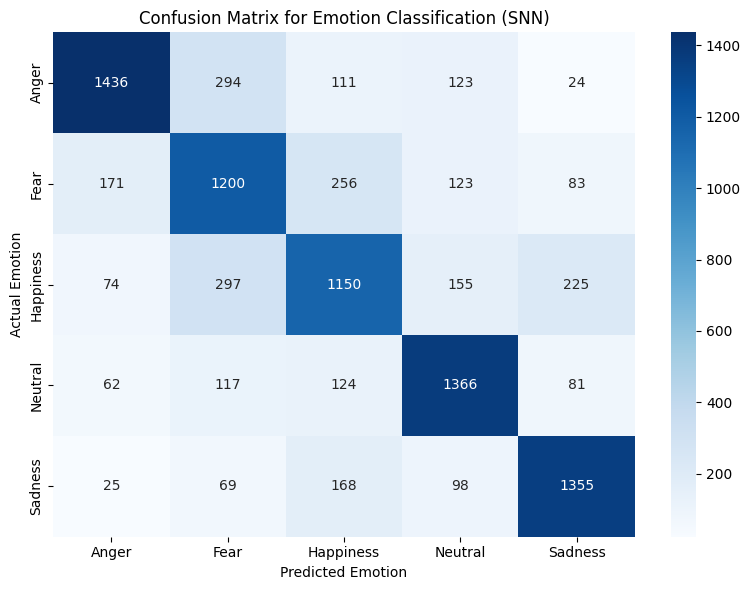

In [28]:
cm = confusion_matrix(y_true, y_pred)
emotion_labels = le.classes_
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('Confusion Matrix for Emotion Classification (SNN)')
plt.xlabel('Predicted Emotion')
plt.ylabel('Actual Emotion')
plt.tight_layout()
plt.show()

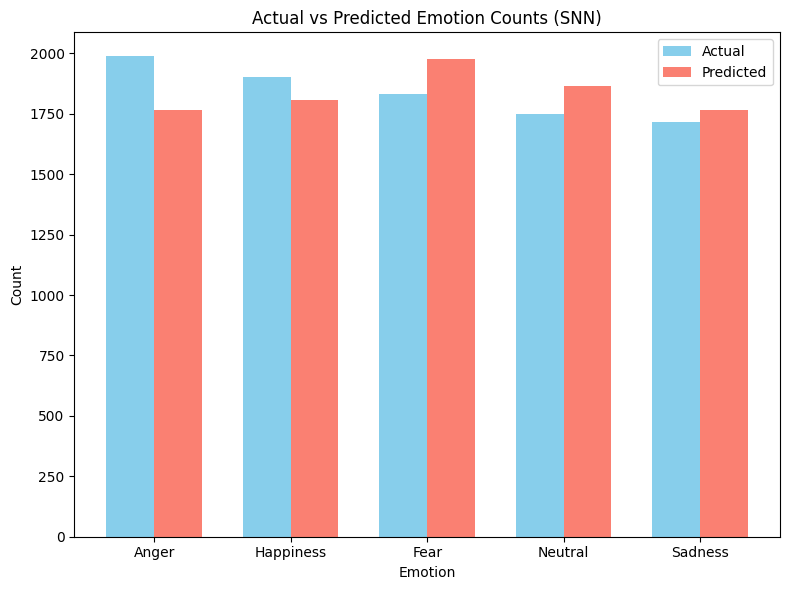

In [29]:
actual_counts = pd.Series(le.inverse_transform(y_true)).value_counts()
predicted_counts = pd.Series(le.inverse_transform(y_pred)).value_counts()
emotions = list(actual_counts.index)
actual_data = [actual_counts.get(emo, 0) for emo in emotions]
predicted_data = [predicted_counts.get(emo, 0) for emo in emotions]

fig, ax = plt.subplots(figsize=(8, 6))
bar_width = 0.35
x = range(len(emotions))
plt.bar(x, actual_data, bar_width, label='Actual', color='skyblue')
plt.bar([i + bar_width for i in x], predicted_data, bar_width, label='Predicted', color='salmon')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Actual vs Predicted Emotion Counts (SNN)')
plt.xticks([i + bar_width/2 for i in x], emotions)
plt.legend()
plt.tight_layout()
plt.show()